# Downstream analysis - Simulate Gene Intervention (Knock out) 

In [1]:
import pandas as pd
import shutil
import tempfile
import os
from tqdm import tqdm

from functions.analysis_utils.stats.stats_proba import compute_mannwhitneyu_test_means

from functions.analysis_utils.genes_intervention.pers_interventions import tailor_bnd_genes_intervention


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table


from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import collect_group_data

from functions.analysis import downstream_analysis


from functions.generate_models import generate_models_re, pre_process_re



In [2]:
genes_diff_expressed_data = pd.read_csv('analysis/Refametinib/genes_models/MEK1_MEK2_target_block/results/genes_diff_expressed/significant_genes_EGF_ON_INVASION.csv')

In [3]:
# genes_diff_expressed_data['diff_mean'] = genes_diff_expressed_data['Group Resistant Mean'] - genes_diff_expressed_data['Group Sensitive Mean']
# genes_diff_expressed_data.head()

# # CCND1 more expressed in sensitive but high variability as well 
# # FOXA1 the more expressed in the resistant 
# # E2F1 smallest p value 

# genes_diff_expressed_data.sort_values(by='diff_mean', ascending=True)
# # genes_diff_expressed_data.sort_values(by='P-value')


### Users data parameters

In [4]:
drug_interest = 'Refametinib'
drug_targets = ['MEK1', 'MEK2']
type_models = 'genes_models'  # 'genes_models' or 'proteins_models'



input_interest = 'EGF'
phenotype_interest = 'INVASION'



gene_diff_expr = f'significant_genes_{input_interest}_ON_{phenotype_interest}'



In [5]:
# genes_to_test = ['FOXA1', 'BIRC5', 'BCL2', 'MDM2', 'E2F1']


genes_to_test = ['CCND1', 'CTNNB1'] # gene that encode cyclin D
number_patients = 35

genetic_intervention = 'KO'

In [6]:
# subdir = f"{'_'.join(drug_targets)}_target_block"
subdir = f"{'_'.join(genes_to_test + [genetic_intervention])}_target_block"


folder_results = f"analysis/{drug_interest}/downstream_analysis/{subdir}/{type_models}"

folder_generic_models = f"analysis/{drug_interest}/downstream_analysis/{subdir}/{type_models}/models/generic"

folder_models = f"analysis/{drug_interest}/downstream_analysis/{subdir}/{type_models}/models_intervention"





In [7]:
# Loading the data (TCGA, cell model passport)

annotations_models = pd.read_csv('data/model_list_20250407.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')

montagud_data = (
    pd.read_csv('data/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
rna_seq_data = pd.read_csv('data/rnaseq_merged/rnaseq_merged_20250117.csv')
cnv_data = pd.read_csv('data/cellmodel_data/cnv_summary_20250207.csv')

proteins_data = pd.read_csv('data/cellmodel_data/proteomics_all_20250211.csv')


models_depmap_annotation = pd.read_csv('data/cellmodel_data/model_list_20250423.csv')



In [8]:
# models inputs
patients_categ = ['resistant', 'sensitive', 'healthy']

inputs_list = ['EGF', 'FGF', 'TGFB', 'ANDROGEN', 'HYPOXIA', 'NUTRIENTS', 'CARCINOGEN', 'ACIDOSIS', 'TNF', 'SPOP']

# models outputs
phenotype_interest = ["PROLIFERATION","INVASION"]



annotations_models = pd.read_csv('data/model_list_20250407.csv')
# Montagud analysis - Growth factors (EGF and FGF), Nutrients and Androgen ON
# Montagud analysis - Carcinogen, Androgen, TNFalpha, Acidosis, and Hypoxia
list_active_inputs =  [['EGF', 'FGF', 'NUTRIENTS', 'ANDROGEN'], 
                        ['CARCINOGEN', 'ANDROGEN', 'TNF', 'ACIDOSIS', 'HYPOXIA']
                        ]


name_montagud_maps = {
        "CASPASE8": "CASP8",
        "CASPASE3": "CASP3",
        "CASPASE9": "CASP9",
        "CYCLINB": "CCNB1",
        "CYCLIND": "CCND1",
        "DSH": "DVL1",
        "BETA_CATENIN": "CTNNB1",
        "E_CADHERIN": "CDH1",
        "CYCC": "CYCS",
        "MEK1_2": "MEK1",
        "NF_KB": "NFKB",
        "SNAIL": "SNAI1",
        "TNFALPHA": "TNF",
        "TSC1_2": "TSC1",
        "BCL_XL": "BCL2L1",
        "MAP3K1_3": "MAP3K1",
        "CHK1_2": "CHK1",
    }

nodes_add = ['MEK2', 'TSC2', 'MAP3K3', 'CHK2']
nodes_to_add = {'MEK1':'MEK2', 'TSC1':'TSC2', 'MAP3K1':'MAP3K3', 'CHK1':'CHK2'}



# proteins synonyms 
synonyms_maps = {
        "RAF1": "RAF",
        "BCL2L2": "BCL2",
        "SMAD1": "SMAD",
        "SMAD3": "SMAD",
        "SMAD4": "SMAD",
        "SMAD5": "SMAD",
        "BAK1": "BAK",
        "GSK3A": "GSK3",
        "GSK3B": "GSK3",
        "TGFBR2": "TGFBR",
        "TGFBR3": "TGFBR",
        "NRAS": "RAS",
        "KRAS": "RAS",
        "HRAS": "RAS",
        "AKT2": "AKT",
        "MYCN": "MYC",
        }

tissue_interest = 'PAN_CANCER'
tissue_remove = 'Haematopoietic and Lymphoid'



# Models parameters
nodes_to_remove = ['FUSED_EVENT', 'AR_ERG']


In [9]:

top_resistant_ids, top_sensitive_ids, top_healthy_ids, montagud_nodes, rna_seq_data_filtered, cnv_data_filtered, table_rna_seq_patients, df_melted_protein, table_proteins_patients = pre_process_re(
    montagud_data,
    rna_seq_data,
    cnv_data,
    number_patients,
    drug_data,
    annotations_models,
    drug_interest,
    proteins_data,
    type_models,
    name_montagud_maps,
    nodes_add,
    synonyms_maps,
    tissue_interest=None,
    tissue_remove=None,
    nodes_to_remove=nodes_to_remove,
)

/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/identification_patients/get_patients_sens_res.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models_filtered.rename(
/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/pre_process_data/pre_process_genes.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data.rename(columns={"gene_symbol": "gene_name"}, inplace=True)
/Users/romane/repos/icr/Attractor-Resistance/functions/generate_utils/pre_process_data/pre_process_proteins.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

preprocessed  proteins


Gene intervention = gene of interest 

In [10]:

dest_dir = f"analysis/{drug_interest}/downstream_analysis/{subdir}/{type_models}/models/generic/"
os.makedirs(dest_dir, exist_ok=True)

# Copy the files
shutil.copy('analysis/generic_models/Montagud2022_Prostate_Cancer.bnd', dest_dir)
shutil.copy('analysis/generic_models/Montagud2022_Prostate_Cancer.cfg', dest_dir) 

'analysis/Refametinib/downstream_analysis/CCND1_CTNNB1_KO_target_block/genes_models/models/generic/Montagud2022_Prostate_Cancer.cfg'

In [11]:
# # simulate a knockin of the gene 
generate_models_re(
    folder_generic_models,
    folder_models,
    top_resistant_ids,
    top_sensitive_ids,
    top_healthy_ids,
    drug_interest,
    drug_targets,
    phenotype_interest,
    rna_seq_data,
    montagud_nodes,
    table_rna_seq_patients,
    cnv_data_filtered,
    name_montagud_maps,
    type_models,
    df_melted_protein,
    table_proteins_patients,
    nodes_to_remove = nodes_to_remove,
    nodes_to_add = nodes_to_add,
    intervention_gene = genes_to_test,
    genetic_intervention= genetic_intervention

)

change manually the bnd files with the node to remove
change manually the bnd files with the node to remove
All .cfg and .bnd files created for sensitive, resistant and healthy patients.
🔍 Processing patient SIDM00415, gene: MEK1
MEK1 node found. Replacing...
SIDM00415: CNV — nodes modified
🔍 Processing patient SIDM00415, gene: MEK2
MEK2 node found. Replacing...
SIDM00415: CNV — nodes modified
🔍 Processing patient SIDM00506, gene: MEK1
MEK1 node found. Replacing...
SIDM00506: CNV — nodes modified
🔍 Processing patient SIDM00506, gene: MEK2
MEK2 node found. Replacing...
SIDM00506: CNV — nodes modified
🔍 Processing patient SIDM00700, gene: MEK1
MEK1 node found. Replacing...
SIDM00700: CNV — nodes modified
🔍 Processing patient SIDM00700, gene: MEK2
MEK2 node found. Replacing...
SIDM00700: CNV — nodes modified
🔍 Processing patient SIDM00710, gene: MEK1
MEK1 node found. Replacing...
SIDM00710: CNV — nodes modified
🔍 Processing patient SIDM00710, gene: MEK2
MEK2 node found. Replacing...
SIDM0

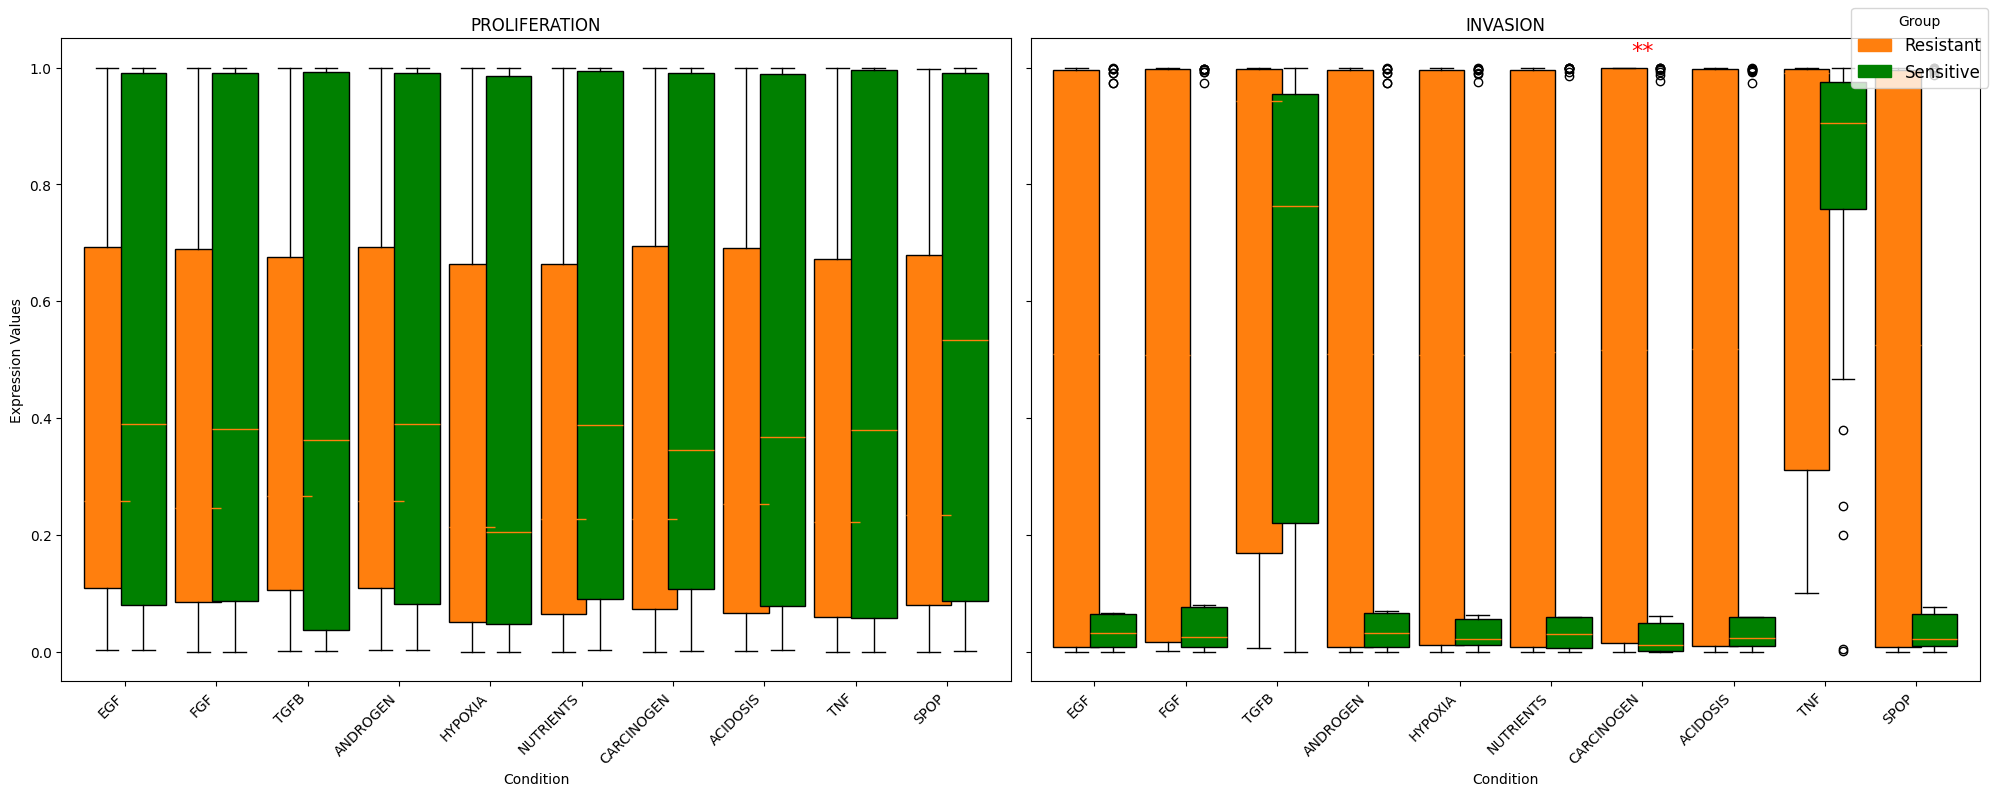

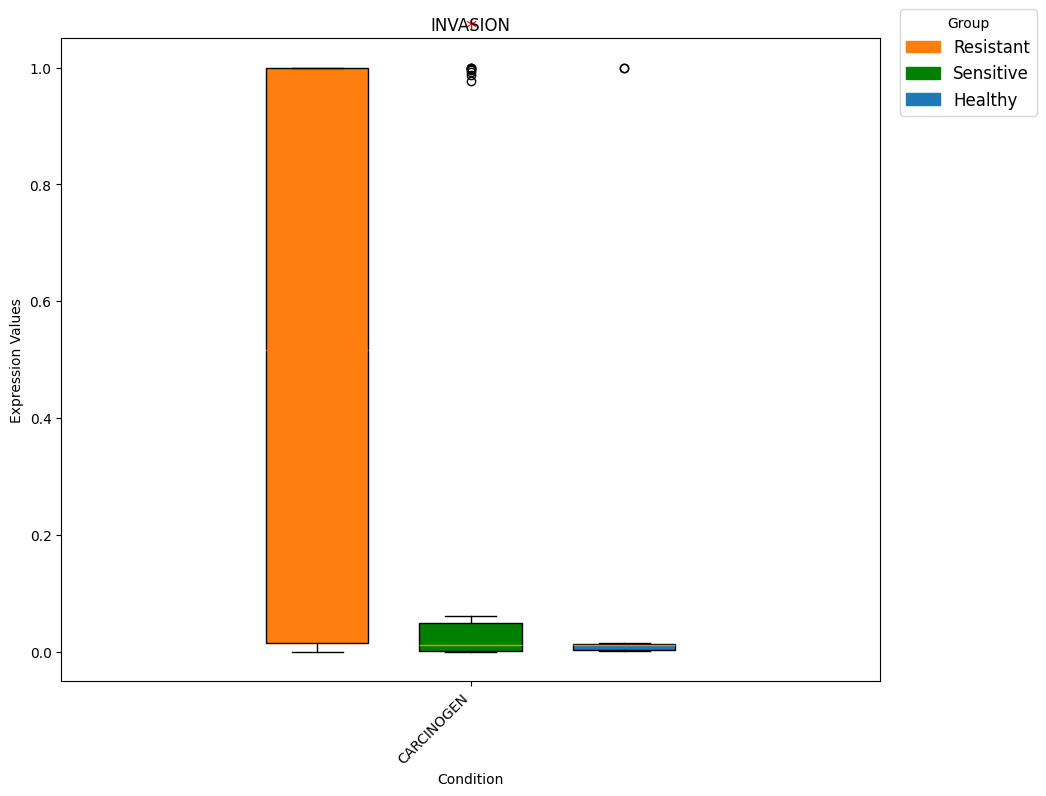

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/MaBoSS_simulation/maboss_phenotype_patient.py:262: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patient_mean.loc[condition][phenotype] = mean
/Users/romane/repos/icr/Attr

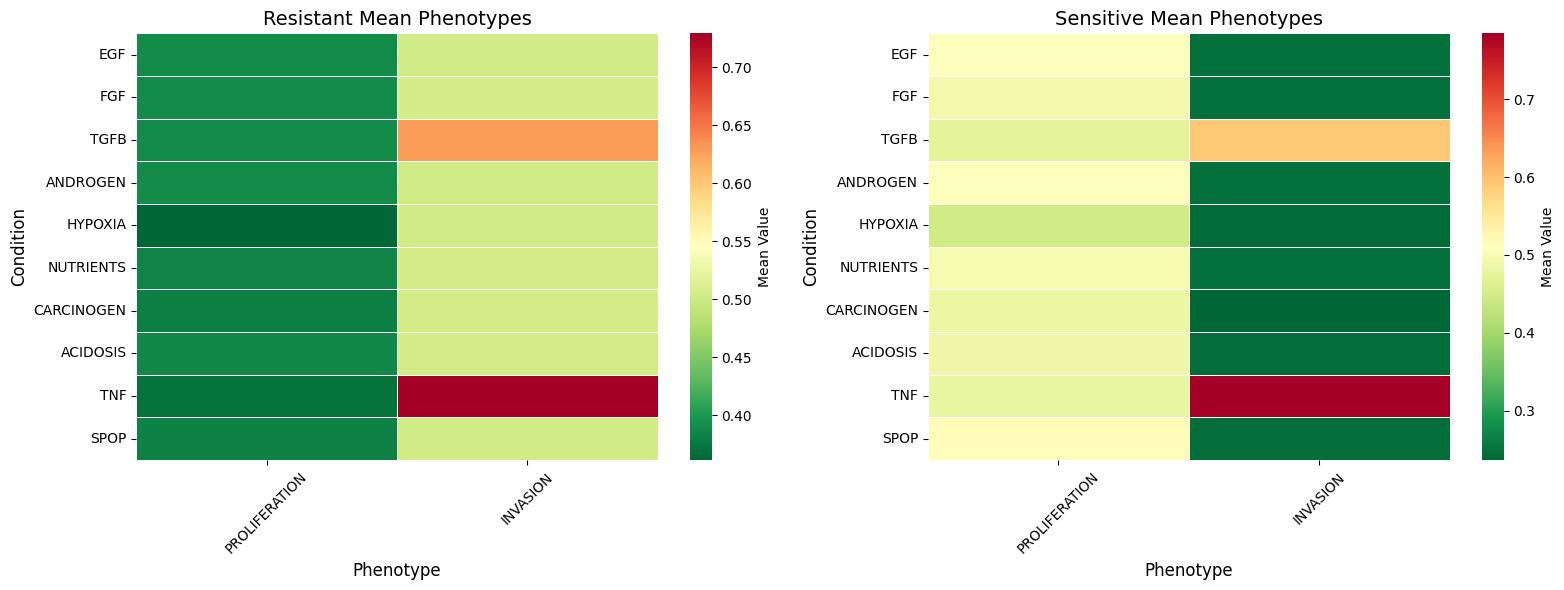

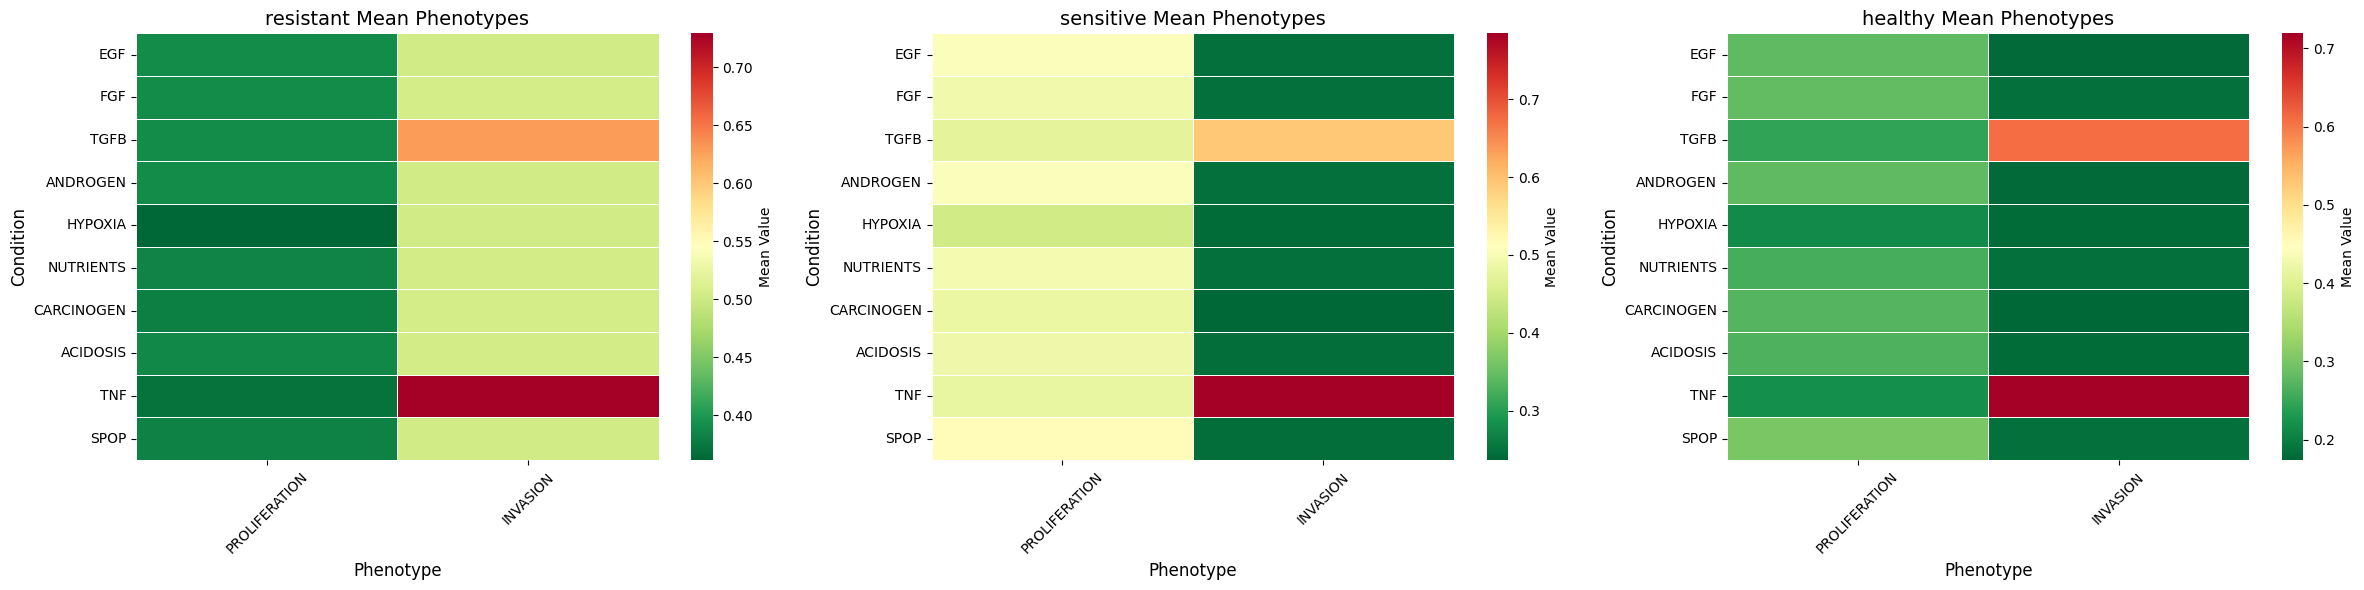

['SIDM01056', 'SIDM00770', 'SIDM00767', 'SIDM01120', 'SIDM00415', 'SIDM00562', 'SIDM00416', 'SIDM00920', 'SIDM00506', 'SIDM00710', 'SIDM00881', 'SIDM00700', 'SIDM00892', 'SIDM00886', 'SIDM00266', 'SIDM00716', 'SIDM00444', 'SIDM00524', 'SIDM01177', 'SIDM00255', 'SIDM00719', 'SIDM00283', 'SIDM00683', 'SIDM00697', 'SIDM00286', 'SIDM00292', 'SIDM00870', 'SIDM00521', 'SIDM00508', 'SIDM00631', 'SIDM00424', 'SIDM00971', 'SIDM00391', 'SIDM01259', 'SIDM01240', 'SIDM01242', 'SIDM00428', 'SIDM00987', 'SIDM00944', 'SIDM00826', 'SIDM00588', 'SIDM01141', 'SIDM00462', 'SIDM00890', 'SIDM01019', 'SIDM00850', 'SIDM00108', 'SIDM00337', 'SIDM01001', 'SIDM01015', 'SIDM00527', 'SIDM00056', 'SIDM00081', 'SIDM00446', 'SIDM00136', 'SIDM00496', 'SIDM00284', 'SIDM00910', 'SIDM00695', 'SIDM00619', 'SIDM00974', 'SIDM01101', 'SIDM00380', 'SIDM01059', 'SIDM00795', 'SIDM00568', 'SIDM01072', 'SIDM01066', 'SIDM00580']
Saved final phenotype table to: analysis/Refametinib/downstream_analysis/CCND1_CTNNB1_KO_target_block/

In [12]:
# for each input ON at a time 
downstream_analysis(folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, top_healthy_ids, patients_categ, inputs_list, phenotype_interest, annotations_models, intervention_gene = genes_to_test, list_active_inputs = None
)


In [13]:
# downstream analysis - CTNNB1 knockout 

res_values_knockout_ctnnb1 = pd.read_csv('analysis/Refametinib/downstream_analysis/CTNNB1_KO_target_block/genes_models/results/resistant/combined_results.csv', index_col = 0)
sens_values_knockout_ctnnb1 = pd.read_csv('analysis/Refametinib/downstream_analysis/CTNNB1_KO_target_block/genes_models/results/sensitive/combined_results.csv', index_col = 0)


# before KO 
res_values = pd.read_csv('analysis/Refametinib/genes_models/MEK1_MEK2_target_block/results/resistant/combined_results.csv', index_col = 0)
sens_values = pd.read_csv('analysis/Refametinib/genes_models/MEK1_MEK2_target_block/results/sensitive/combined_results.csv', index_col = 0)


In [14]:
import ast

res_values_knockout_ctnnb1 = res_values_knockout_ctnnb1.applymap(ast.literal_eval)
sens_values_knockout_ctnnb1 = sens_values_knockout_ctnnb1.applymap(ast.literal_eval)

res_values = res_values.applymap(ast.literal_eval)
sens_values = sens_values.applymap(ast.literal_eval)

/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_17802/4135175964.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res_values_knockout_ctnnb1 = res_values_knockout_ctnnb1.applymap(ast.literal_eval)
/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_17802/4135175964.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sens_values_knockout_ctnnb1 = sens_values_knockout_ctnnb1.applymap(ast.literal_eval)
/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_17802/4135175964.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res_values = res_values.applymap(ast.literal_eval)
/var/folders/83/pqwsm5cn7vscbq8l3fnf30qr0000gn/T/ipykernel_17802/4135175964.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sens_values = sens_values.applymap(ast.literal_eval)


In [15]:
res_values_knockout = res_values_knockout_ctnnb1.loc['EGF', 'INVASION']
res_values = res_values.loc['EGF', 'INVASION']


sens_values_knockout = sens_values_knockout_ctnnb1.loc['EGF', 'INVASION']
sens_values = sens_values.loc['EGF', 'INVASION']

In [16]:
mean_mean_sens_ko = sum(sens_values_knockout) / len(sens_values_knockout)
mean_sens = sum(sens_values) / len(sens_values)


In [17]:
# stats test 
from scipy.stats import mannwhitneyu


stat, p_value = mannwhitneyu(sens_values_knockout, sens_values, alternative='two-sided')

print("Mann–Whitney U statistic:", stat)
print("p-value:", p_value)

Mann–Whitney U statistic: 282.0
p-value: 0.00010587444450594736


In [18]:
mean_res_ko = sum(res_values_knockout) / len(res_values_knockout)
mean_res = sum(res_values) / len(res_values)


In [19]:
mean_res_ko

0.5025415588235295

In [20]:
mean_res

0.768888705882353

Results 
- sensitive -> significant difference between the two populations (0.0001)
- resistant -> not significant (0.09)

In [21]:
with open('analysis/Refametinib/top_resistant_ids.txt', 'r') as file:
    res_ids = file.read().splitlines()  # returns a list of names (one per line)

with open('analysis/Refametinib/top_sensitive_ids.txt', 'r') as file:
    sens_ids = file.read().splitlines()


In [22]:
mutations_data = pd.read_csv('data/cellmodel_data/mutations_all_20250318.csv')


In [23]:
'pi3k' in [gene.lower() for gene in set(mutations_data['gene_symbol'])]


False

In [24]:
res_mut = mutations_data[
    (mutations_data['model_id'].isin(res_ids)) &
    (mutations_data['gene_symbol'] == 'KRAS')
]

sens_mut = mutations_data[
    (mutations_data['model_id'].isin(sens_ids)) &
    (mutations_data['gene_symbol'] == 'KRAS')
]


print('res mutations:', res_mut['effect'].value_counts())
print('sens mutations:', sens_mut['effect'].value_counts())

res mutations: effect
intronic      2
frameshift    1
Name: count, dtype: int64
sens mutations: effect
missense    9
intronic    1
Name: count, dtype: int64
